### 데이터 및 학습 목표
AWS paper: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html

농업 on 사이트에서 방울토마토에 대한 5kg 도매 가격에 대한 데이터를 (평균,최대,최소) 가지고 예측이 가능할까요?
https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/aws-forecast-recipe-deeparplus.html

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Input, Dense, LSTM, Dropout, TimeDistributed, Lambda, RepeatVector

# 클래스
class DeepAR(tf.keras.models.Model):
  # init => initialize
    def __init__(self, lstm_units, n_steps_in, n_steps_out, n_features):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, input_shape=(n_steps_in, n_features))

        self.dense_mu = tf.keras.layers.Dense(1) # 정규분포 (가우시안 분포)의 평균
        self.dense_sigma = tf.keras.layers.Dense(1, activation='softplus') # 정규분포 (가우시안 분포)의 시그마
    # 모델을 호출한다 => 모델에 입력이 들어간다.
    def call(self, inputs, initial_state=None):
        outputs, state_h, state_c = self.lstm(inputs, initial_state=initial_state) # LSTM에 입력을 넣는다.
        mu = self.dense_mu(outputs)
        sigma = self.dense_sigma(outputs) 
        state = [state_h, state_c]
        return [mu, sigma, state]

# 모델의 loss를 계산
def log_gaussian_loss(mu, sigma, y_true):
    """
    Gaussian loss function
    """
                              # 모델링된 mu와 sigma를 가지고 분포 생성
                                                                    # y_true=실제값과 분포에서 샘플링된 값의 차이를 구함.
    return -tf.reduce_sum(tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(y_true))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from datetime import datetime, timedelta


df = pd.read_csv('https://drive.google.com/drive/...',  header=0, # 데이터 생략
    infer_datetime_format=True, # 날짜시간 포맷 추정해서 파싱하기
    parse_dates=['date'],
    index_col=['date'])

In [ ]:
df.columns

In [ ]:
df = df.sort_index().drop(['fruit','per','grade'] , axis=1)

In [ ]:
test_cutoff_date = df.index.max() - timedelta(days=90)

df_test = df[df.index > test_cutoff_date]['average'] # 테스트
df_train = df[df.index <= test_cutoff_date]['average'] # 학습
# 데이터를 정규화
training_mean = df_train.mean() # train의 평균
training_std = df_train.std() # train의 편차
df_training_value = (df_train - training_mean) / training_std # 데이터 = (원본 - 평균) / 편차로 정규화

test_mean = df_test.mean()
test_std = df_test.std()
df_test_value = (df_test - training_mean) / training_std

from numpy import array

def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

raw_seq = df_training_value
n_steps_in = 30
n_steps_out = 1

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

test_raw_seq = df_test_value

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

https://gooopy.tistory.com/62

In [ ]:
LSTM_UNITS = 1024
EPOCHS = 10000

model = DeepAR(LSTM_UNITS, n_steps_in, n_steps_out, n_features)

# optmizer
optimizer = tf.keras.optimizers.Adam()


# metric
rmse = tf.keras.metrics.RootMeanSquaredError()

def train_step(x, y):
    with tf.GradientTape() as tape:
        mu, sigma, _ = model(x)
        loss = log_gaussian_loss(mu, sigma, y) # Forward Learning
    # backword
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    rmse(y, mu)

for epoch in range(EPOCHS):
    train_step(X, y)
    print('Epoch %d, RMSE %.4f' % (epoch + 1, rmse.result().numpy()))
    rmse.reset_states()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 5001, RMSE 0.6481
Epoch 5002, RMSE 0.6467
Epoch 5003, RMSE 0.6460
Epoch 5004, RMSE 0.6448
Epoch 5005, RMSE 0.6503
Epoch 5006, RMSE 0.7243
Epoch 5007, RMSE 0.8203
Epoch 5008, RMSE 0.9179
Epoch 5009, RMSE 0.9133
Epoch 5010, RMSE 0.8634
Epoch 5011, RMSE 0.8328
Epoch 5012, RMSE 0.8201
Epoch 5013, RMSE 0.7933
Epoch 5014, RMSE 0.7884
Epoch 5015, RMSE 0.7905
Epoch 5016, RMSE 0.7889
Epoch 5017, RMSE 0.7858
Epoch 5018, RMSE 0.7822
Epoch 5019, RMSE 0.7755
Epoch 5020, RMSE 0.7674
Epoch 5021, RMSE 0.7577
Epoch 5022, RMSE 0.7483
Epoch 5023, RMSE 0.7410
Epoch 5024, RMSE 0.7365
Epoch 5025, RMSE 0.7346
Epoch 5026, RMSE 0.7331
Epoch 5027, RMSE 0.7298
Epoch 5028, RMSE 0.7250
Epoch 5029, RMSE 0.7199
Epoch 5030, RMSE 0.7155
Epoch 5031, RMSE 0.7117
Epoch 5032, RMSE 0.7081
Epoch 5033, RMSE 0.7049
Epoch 5034, RMSE 0.7018
Epoch 5035, RMSE 0.6985
Epoch 5036, RMSE 0.6953
Epoch 5037, RMSE 0.6929
Epoch 5038, RMSE 0.6904
Epoch 5039, RMSE 0.6875
Epoch 5040, RMSE 0.6849
Epoc

In [ ]:
# 샘플링된 값들을 예측값으로 반환.
pred = model.predict(test_X)

In [ ]:
pred[0].shape

# median => 실제 예측값.
# 5% 퍼센타일 => lower bound
# 95% 퍼센타일 => upper bound

(48, 30, 1)

In [ ]:
test_y.shape # 라벨의 shape

(48, 1)

In [ ]:
pred

[array([[[ 0.03122767],
         [-0.07425452],
         [ 0.03599206],
         ...,
         [ 0.01123137],
         [ 0.01329242],
         [ 0.01538459]],
 
        [[ 0.0187658 ],
         [ 0.02024392],
         [ 0.25190625],
         ...,
         [ 0.5269283 ],
         [ 0.5331662 ],
         [ 0.54013616]],
 
        [[ 0.09802438],
         [ 0.20332682],
         [ 0.05195478],
         ...,
         [-0.33897004],
         [-0.36416698],
         [-0.37354833]],
 
        ...,
 
        [[-0.09955432],
         [-0.24083513],
         [-0.27118137],
         ...,
         [-0.58503175],
         [-0.21500346],
         [-0.06256063]],
 
        [[-0.11957051],
         [-0.19191553],
         [-0.32045847],
         ...,
         [-0.22590655],
         [-0.06930166],
         [-0.18402693]],
 
        [[-0.07896001],
         [-0.25465345],
         [-0.2740324 ],
         ...,
         [-0.06529351],
         [-0.19086239],
         [-0.41291344]]], dtype=float32), arra

In [ ]:
test_y

array([[-0.77219763],
       [-0.7882473 ],
       [-0.81834045],
       [-0.81397399],
       [-0.71024115],
       [-0.69041508],
       [-0.76547092],
       [-0.67353932],
       [-0.6628002 ],
       [ 0.13319297],
       [-0.07781308],
       [-0.25730983],
       [-0.63140892],
       [-0.63459525],
       [-0.86625345],
       [-0.68404242],
       [-0.75119143],
       [-0.61429713],
       [-0.76134049],
       [-0.76322869],
       [-0.83852056],
       [-0.62657041],
       [-0.54042141],
       [-0.8006386 ],
       [-0.90142113],
       [-1.00763222],
       [-0.8159802 ],
       [-0.62539029],
       [-0.57228474],
       [-0.62881265],
       [-0.61819154],
       [-0.54301768],
       [-0.71295544],
       [-0.23347134],
       [-0.11333479],
       [-0.37992464],
       [-0.53322266],
       [-0.79355786],
       [-0.93706085],
       [-1.04173779],
       [-0.75260758],
       [-0.86601743],
       [-0.42819169],
       [ 0.717354  ],
       [ 1.87540899],
       [ 1

In [ ]:
import numpy as np
lower_bound = []
upper_bound = []
median = []
for step_pred in pred[0]:
                           # 정규화된 값을 원래대로.
  lb = (np.quantile(step_pred, 0.05) + test_mean) * test_std
  ub = (np.quantile(step_pred, 0.95) + test_mean) * test_std
  med = (np.quantile(step_pred, 0.5) + test_mean) * test_std
  lower_bound.append(lb)
  upper_bound.append(ub)
  median.append(med)

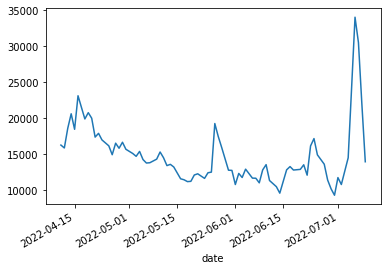

In [ ]:
df_test.plot()

### 결론

작물 도매 비용 예측을 위해서는 univariate(= 시간에 따른 관측치가 1개인 데이터)보다는  multivariate(= 시간에 따른 관측치가 N개인 데이터)를 이용해야한다. -> 도메인 지식을 쌓는것에 많이 준비해야..

In [ ]:
lower_bound

[63629652.68451568,
 63630540.27521958,
 63628180.5744184,
 63627197.768985145,
 63628126.096201204,
 63627567.94306469,
 63631283.548557736,
 63630008.92956348,
 63628955.55977245,
 63628802.29311853,
 63628679.41110531,
 63627396.69263472,
 63628192.348646484,
 63627494.86313398,
 63629350.02899661,
 63628893.50310175,
 63626939.18223053,
 63626926.081244506,
 63626989.732305095,
 63627039.6209529,
 63627624.56269348,
 63627981.35062325,
 63627663.98155101,
 63627259.04435526,
 63627237.645462945,
 63627955.69068105,
 63628043.225419715,
 63627266.49917039,
 63627435.908334374,
 63627651.12957135,
 63627063.21907297,
 63626983.02932922,
 63626775.11944796,
 63626573.16024548,
 63626644.55722427,
 63626813.1857045,
 63626913.78606035,
 63627447.524400994,
 63629839.89740652,
 63629457.130887404,
 63627032.66451933,
 63627808.73956719,
 63627770.355118185,
 63627471.73367344,
 63627238.785507455,
 63627463.18358127,
 63627372.22194309,
 63627588.001489006]

In [ ]:
upper_bound

[63630625.0167089,
 63632720.64288554,
 63631122.82573103,
 63631313.081408165,
 63632616.012642786,
 63631677.72523852,
 63634414.6416583,
 63630928.33129554,
 63630909.93724527,
 63631074.278699026,
 63631848.950623505,
 63630292.25117439,
 63631354.68665779,
 63631269.20440621,
 63631399.950043015,
 63630662.649639785,
 63630058.7743436,
 63629920.60421463,
 63629923.74641779,
 63629871.73667229,
 63630232.20920232,
 63630598.986245885,
 63630448.78019304,
 63630432.21675661,
 63630190.352210365,
 63630330.8236786,
 63630960.61284682,
 63631266.511747375,
 63631251.323255144,
 63630345.118223436,
 63629441.47481032,
 63629311.4253205,
 63629352.997868866,
 63629438.66068791,
 63629736.00253635,
 63629943.68355977,
 63629853.39265476,
 63630022.71691156,
 63631543.91301361,
 63630918.84428812,
 63631059.41629082,
 63630833.57978517,
 63630003.44386714,
 63629365.96781465,
 63629562.34765088,
 63629810.80611349,
 63629823.31206089,
 63629915.03688759]